## Model Development

In [2]:
%reload_ext autoreload
%autoreload 1

In [24]:
from pathlib import Path
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse as ssp
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.auto import tqdm

from src.metrics import Gini, gini_normalized
from src.process import load_train_test
from src.score import load_predictions

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
def eval_gini(preds, dtrain):
    """Custom Callback to Implement Gini for Early Stopping.
    """
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

In [23]:
LABEL = "target"
NFOLDS = 5

SAVE_PLOTS = True  # If true save plots as .png files in PLOT_DIR

DIR = Path("data")
PLOT_DIR = DIR.joinpath("plots")
MODEL_DIR = DIR.joinpath("models")

os.makedirs(DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

CV_NAME = "cv_scores.snap.parquet"
TEST_NAME = "model_scores.snap.parquet"

CV_PATH = DIR.joinpath(CV_NAME)
TEST_PATH = DIR.joinpath(TEST_NAME)

In [8]:
train, test = load_train_test()

train_id = train["id"]
test_id = test["id"]
train_label = train[LABEL]

kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

FEATURES = train.columns.tolist()
CALC_FEATURES = [c for c in FEATURES if "calc" in c]
RM_FEATURES = CALC_FEATURES + [LABEL, "id"]

y = train[LABEL].values
X = train.drop(RM_FEATURES, axis=1)

features = X.columns.tolist()
cat_features = [c for c in features if ("cat" in c and "count" not in c)]
num_features = [c for c in features if ("cat" not in c and "calc" not in c)]
ind_features = [c for c in features if "ind" in c]

### Feature Processing

In [9]:
%%time

for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])


count = 0
for c in ind_features:
    if count == 0:
        train["new_ind"] = train[c].astype(str) + "_"
        test["new_ind"] = test[c].astype(str) + "_"
        count += 1
    else:
        train["new_ind"] += train[c].astype(str) + "_"
        test["new_ind"] += test[c].astype(str) + "_"

cat_count_features = []
for c in cat_features + ["new_ind"]:
    d = pd.concat([train[c], test[c]]).value_counts().to_dict()
    train["%s_count" % c] = train[c].apply(lambda x: d.get(x, 0))
    test["%s_count" % c] = test[c].apply(lambda x: d.get(x, 0))
    cat_count_features.append("%s_count" % c)

train_list = [
    train[num_features + cat_count_features].values,
    X_cat,
]
test_list = [
    test[num_features + cat_count_features].values,
    X_t_cat,
]

CPU times: user 26.4 s, sys: 6.07 s, total: 32.5 s
Wall time: 32.5 s


### Model Params
- Specifiy model parameters

In [10]:
N_SEEDS = 1  # of random seeds to train to reduce variance due to randomness

X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2_000
feature_fraction = 0.6
num_boost_round = 10_000

params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9,
          "force_row_wise": True,
          "metrics": ["auc"],
          }

### Model Fitting and Cross-Validation

- Create local cross-validation schema {NFOLDS}-StratifiedKFold with {N_SEEDS} models averaged to reduce variance
- Implement custom `Gini` callback to use with early stopping
    - Stop training when the validation performance is no longer increasing after 100 iterations
    - Gini is used because that is the metric the contest is ranked on
        - It seems this can be unstable for imbalanced datasets if given more time I'd consider a different loss function perhaps focal loss
        - Monitor AUC as well

In [11]:
%%time
MODELS = []
fold_scores = []

final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))

for s in tqdm(range(N_SEEDS)):

    params['seed'] = s
    cv_train = np.zeros(len(train_label))
    cv_preds = np.zeros(len(test_id))
    kf = kfold.split(X, train_label)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):

        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(params,
                        dtrain,
                        num_boost_round,
                        valid_sets=[dtrain, dvalid],
                        feval=[eval_gini],
                        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True, first_metric_only=False)]
                       )
        model_name = f"lgb_{s}_fold_{int(i + 1)}.txt"
        bst.save_model(MODEL_DIR.joinpath(model_name))
        MODELS.append(bst)
        best_trees.append(bst.best_iteration)

        cv_preds += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)
        score = Gini(label_validate, cv_train[validate])
        print(f"CV Score [{i + 1} of {NFOLDS}]: {score:,.4f}")
        fold_scores.append(score)

    cv_preds /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_preds

    _cv_score = Gini(train_label, cv_train)
    print(f"CV Score: {_cv_score:,.4f}")
    print(f"Scores by Fold: {[_.round(4) for _ in fold_scores]}")
    print(f"Best Trees: {best_trees} Avg: {np.mean(best_trees):,.4f}")
    fold_scores.append(Gini(train_label, cv_train))

  0%|          | 0/1 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	training's auc: 0.673722	training's gini: 0.347444	valid_1's auc: 0.646092	valid_1's gini: 0.292184
CV Score [1 of 5]: 0.2922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's auc: 0.67618	training's gini: 0.35236	valid_1's auc: 0.641861	valid_1's gini: 0.283723
CV Score [2 of 5]: 0.2837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's auc: 0.683364	training's gini: 0.366727	valid_1's auc: 0.643091	valid_1's gini: 0.286181
CV Score [3 of 5]: 0.2862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's auc: 0.683739	training's gini: 0.367478	valid_1's auc: 0.644951	valid_1's gini: 0.289902
CV Score [4 of 5]: 0.2899
Training until validation scores don't improve for 100 rounds
Early stopping, best ite

100%|██████████| 1/1 [05:34<00:00, 334.56s/it]

CPU times: user 29min 55s, sys: 4.81 s, total: 30min
Wall time: 5min 34s


In [13]:
# Create DataFrames of CV and Out-of-Sample Score and Save to Disk

dfout = pd.DataFrame({'id': test_id, 'target': final_cv_pred / N_SEEDS})     # out-of-sample predictions
dfcv  = pd.DataFrame({'id': train_id, 'target': final_cv_train / N_SEEDS})   # cv predictions


dfout.to_parquet(TEST_PATH)
dfcv.to_parquet(CV_PATH)

dfout.to_csv(str(TEST_PATH).replace("snap.parquet", "csv"), index=False)
dfcv.to_csv(str(CV_PATH).replace("snap.parquet", "csv"), index=False)

dfall = pd.concat([
    dfcv.assign(Type="CV"),
    dfout.assign(Type="Test")])

### Check the Distribution of CV Scores vs. Out-of-Sample

Basic sanity check to ensure the distribution of `out-of-sample` predictions matches the predictions from local cross-validation.

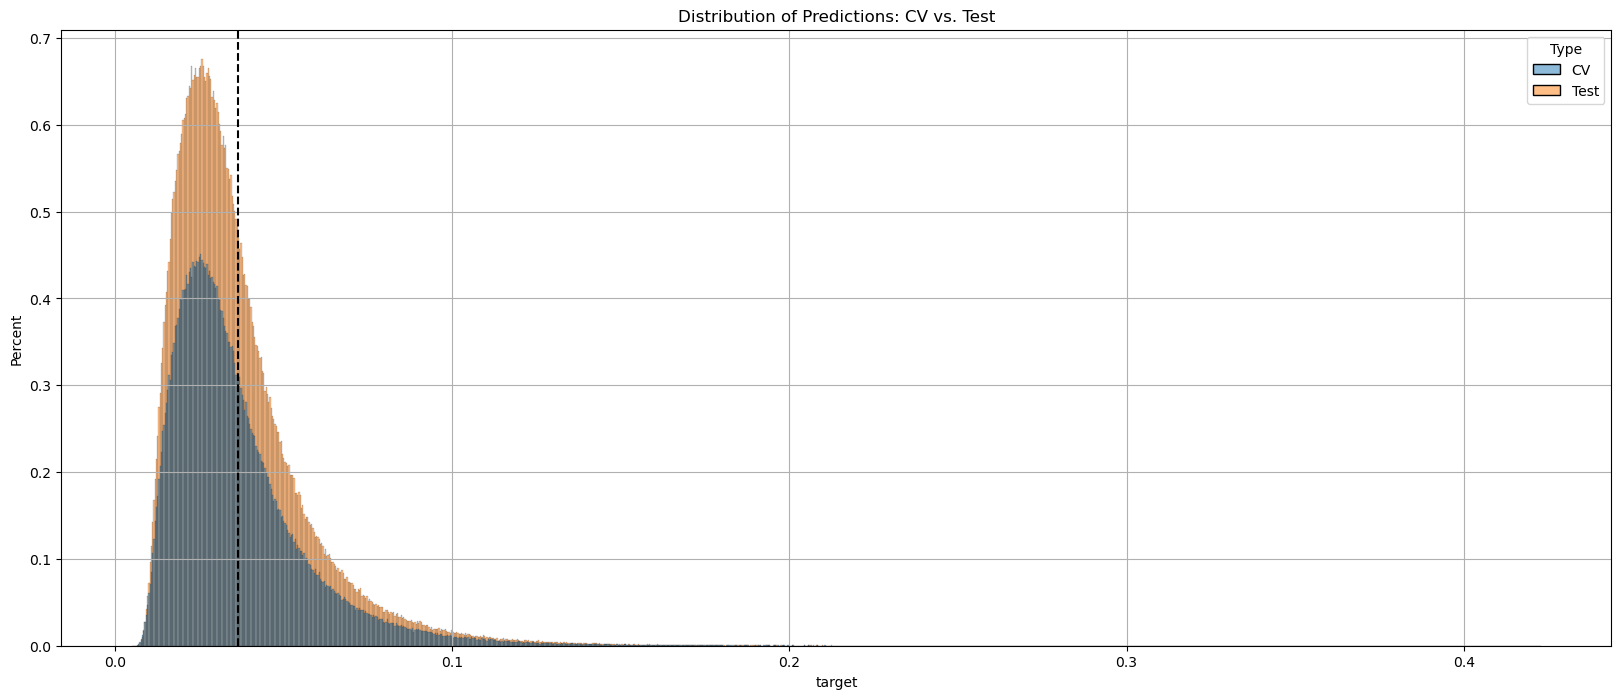

In [14]:
f, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.histplot(dfall, x=LABEL, hue="Type", ax=ax, stat="percent")
ax.grid()
ax.axvline(train[LABEL].mean(), linestyle="--", color="black")
plt.title(f"Distribution of Predictions: CV vs. Test")
if SAVE_PLOTS:
    plt.savefig(PLOT_DIR.joinpath("Model-CV-Distribution-vs-Out-Of-Sample.png"))
plt.show()

In [15]:
TRUE_LABEL = "actual"
PRED_LABEL = "pred_label"

df_actuals = train[["id", LABEL]].rename(columns={LABEL: TRUE_LABEL})
dfscore = dfcv.merge(df_actuals)
dfscore["pred_naive"] = 0

### Determine Optimal Decision Threshold

- Evaluate performance metrics across several decision thresholds
- Scores calculated of probability prediction: Gini, roc, should be constant
- Aim for PositiveRae to be close to the train sample observed rate of occurance, maximize acc, f1, etc

In [16]:
res = []

for thresh in np.arange(.03, .15, .005):
    d = {}
    d["thresh"] = thresh
    dfscore[PRED_LABEL] = np.where(dfscore[LABEL] >= thresh, 1, 0)

    d["NClaims"] = dfscore[TRUE_LABEL].sum()
    d["NClaimsPredicted"] = dfscore[PRED_LABEL].sum()
    d["Gini_"] = Gini(dfscore[TRUE_LABEL], dfscore[LABEL])
    d["Gini"] = gini_normalized(dfscore[TRUE_LABEL], dfscore[LABEL])
    
    d["roc"] = roc_auc_score(dfscore[TRUE_LABEL], dfscore[LABEL])
    d["Accuracy"] = accuracy_score(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])

    tn, fp, fn, tp = confusion_matrix(dfscore[TRUE_LABEL], dfscore[PRED_LABEL]).ravel()
    d["TP"] = tp
    d["TN"] = tn
    d["FN"] = fn
    d["FP"] = fp
    d["f1_score"] = f1_score(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])
    res.append(d)

In [17]:
dfr = pd.DataFrame(res)
dfr["PositiveRate"] = dfr["NClaimsPredicted"] / len(dfscore)

In [18]:
dfr[(dfr["Accuracy"] > .9)].sort_values("f1_score", ascending=False)

,thresh,NClaims,NClaimsPredicted,Gini_,Gini,roc,Accuracy,TP,TN,FN,FP,f1_score,PositiveRate
8,0.070,21694,39236,0.286066,0.286066,0.643033,0.909222,3449,537731,18245,35787,0.113212,0.065919
9,0.075,21694,30868,0.286066,0.286066,0.643033,0.921221,2836,545486,18858,28032,0.107911,0.051861
10,0.080,21694,24393,0.286066,0.286066,0.643033,0.930416,2335,551460,19359,22058,0.101330,0.040982
11,0.085,21694,19300,0.286066,0.286066,0.643033,0.937612,1930,556148,19764,17370,0.094160,0.032425
12,0.090,21694,15377,0.286066,0.286066,0.643033,0.943081,1596,559737,20098,13781,0.086105,0.025834
13,0.095,21694,12189,0.286066,0.286066,0.643033,0.947472,1309,562638,20385,10880,0.077266,0.020478
14,0.100,21694,9725,0.286066,0.286066,0.643033,0.950883,1092,564885,20602,8633,0.069512,0.016339
15,0.105,21694,7848,0.286066,0.286066,0.643033,0.953435,913,566583,20781,6935,0.061810,0.013185
16,0.110,21694,6268,0.286066,0.286066,0.643033,0.955602,768,568018,20926,5500,0.054932,0.010531
17,0.115,21694,5030,0.286066,0.286066,0.643033,0.957269,645,569133,21049,4385,0.048271,0.008451


### Calculate Predictions with Optimal Threshold

In [19]:
THRESH = .08
dfscore["pred_naive"] = 0
dfscore[PRED_LABEL] = np.where(dfscore[LABEL] >= THRESH, 1, 0)

In [20]:

tn_naive, fp_naive, fn_naive, tp_naive = confusion_matrix(dfscore[TRUE_LABEL], dfscore["pred_naive"]).ravel()
confusion_matrix(dfscore[TRUE_LABEL], dfscore["pred_naive"])

print("-" * 30)
print("**Naive Classification Report**")
print("-" * 30)
print(classification_report(dfscore[TRUE_LABEL], dfscore["pred_naive"], target_names=["No Claim", "Makes Claim"], digits=4))

gini_naive = Gini(dfscore[TRUE_LABEL], dfscore["pred_naive"])
print(f"Gini:\n{gini_naive:.4f}")

------------------------------
**Naive Classification Report**
------------------------------
              precision    recall  f1-score   support

    No Claim     0.9636    1.0000    0.9814    573518
 Makes Claim     0.0000    0.0000    0.0000     21694

    accuracy                         0.9636    595212
   macro avg     0.4818    0.5000    0.4907    595212
weighted avg     0.9284    0.9636    0.9457    595212

Gini:
-0.0015


In [21]:
tn, fp, fn, tp = confusion_matrix(dfscore[TRUE_LABEL], dfscore[PRED_LABEL]).ravel()
confusion_matrix(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])


print("-" * 30)
print("Model Classification Report")
print("-" * 30)

print(classification_report(dfscore[TRUE_LABEL], dfscore[PRED_LABEL], target_names=["No Claim", "Makes Claim"], digits=4))

gini_model = Gini(dfscore[TRUE_LABEL], dfscore[LABEL])
print(f"Gini:\n{gini_model:.4f}")

------------------------------
Model Classification Report
------------------------------
              precision    recall  f1-score   support

    No Claim     0.9661    0.9615    0.9638    573518
 Makes Claim     0.0957    0.1076    0.1013     21694

    accuracy                         0.9304    595212
   macro avg     0.5309    0.5346    0.5326    595212
weighted avg     0.9344    0.9304    0.9324    595212

Gini:
0.2861


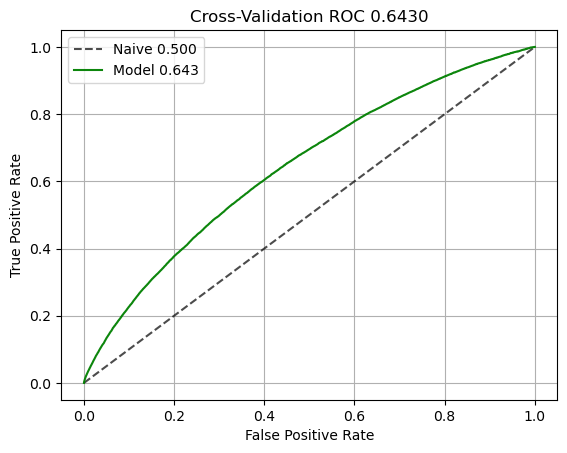

Bad pipe message: %s [b'\xb6\x9d\x16\xc0\xc8\xfd\xbdC\x1eQ\x1e6\n\xcc\x87]B\x9b >\x95M\xf5\xebz\xbb\xb6\xd5']
Bad pipe message: %s [b'\xa2\xb2\x93OX\x1e\xbc\xf8xap_', b'\xad\xd7i\xad\xf2\x97x\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 9\xdd\xa61\xf6\x828\xf4\x08\xf0\x97\xc4\xbe\x1f\x1e\x93\xdb(\xcd~\xd7J']
Bad pipe message: %s [b'Bs\xe6h$\xb2\xff\xed&\xe7\xbe\xe8G\xd1\xaep.\x7f \xa7\x1f2G\xe9E\x87\xc0\xdc\x01\xdd\xc5Frd\xe2\xc5\x08\x17\x01\xafb\xa1\x08\xdf\xf9\x07EHw\xe8\xb1\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00

In [22]:
roc_naive = roc_auc_score(dfscore[TRUE_LABEL], dfscore["pred_naive"])
roc_model = roc_auc_score(dfscore[TRUE_LABEL], dfscore[LABEL])

fpr_naive, tpr_naive, _ = roc_curve(dfscore[TRUE_LABEL], dfscore["pred_naive"])

fpr, tpr, _ = roc_curve(dfscore[TRUE_LABEL], dfscore[LABEL])

plt.plot(fpr_naive, tpr_naive, label=f"Naive {roc_naive:.3f}", alpha=0.7, color="black", linestyle="--")
plt.plot(fpr, tpr, label=f"Model {roc_model:.3f}", color="Green", alpha=0.95)

plt.legend(loc="upper left")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.rcParams["figure.figsize"] = (12, 8)
plt.title(f"Cross-Validation ROC {roc_model:.4f}")
plt.grid()

if SAVE_PLOTS:
    fname = PLOT_DIR.joinpath(f"Model-ROC.png")
    plt.savefig(fname)
plt.show()